In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.preprocessing import StandardScaler as SS
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_excel("OnlineRetail.xlsx")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df["CustomerID"] = df["CustomerID"].fillna(df["CustomerID"].mode()[0])

df["InvoiceNo"] = df["InvoiceNo"].astype('str')
df["InvoiceNo"] = LE().fit_transform(df["InvoiceNo"])
df["StockCode"] = df["StockCode"].astype('str')
df["StockCode"] = LE().fit_transform(df["StockCode"])
df["Description"] = df["Description"].astype('str')
df["Description"] = LE().fit_transform(df["Description"])
df["InvoiceDate"] = df["InvoiceDate"].astype('str')
df["InvoiceDate"] = LE().fit_transform(df["InvoiceDate"])
df["Country"] = df["Country"].astype('str')
df["Country"] = LE().fit_transform(df["Country"])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,3536,3918,6,0,2.55,17850.0,36
1,0,2794,3926,6,0,3.39,17850.0,36
2,0,3044,913,8,0,2.75,17850.0,36
3,0,2985,1910,6,0,3.39,17850.0,36
4,0,2984,2911,6,0,3.39,17850.0,36


C:\Users\anaal\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


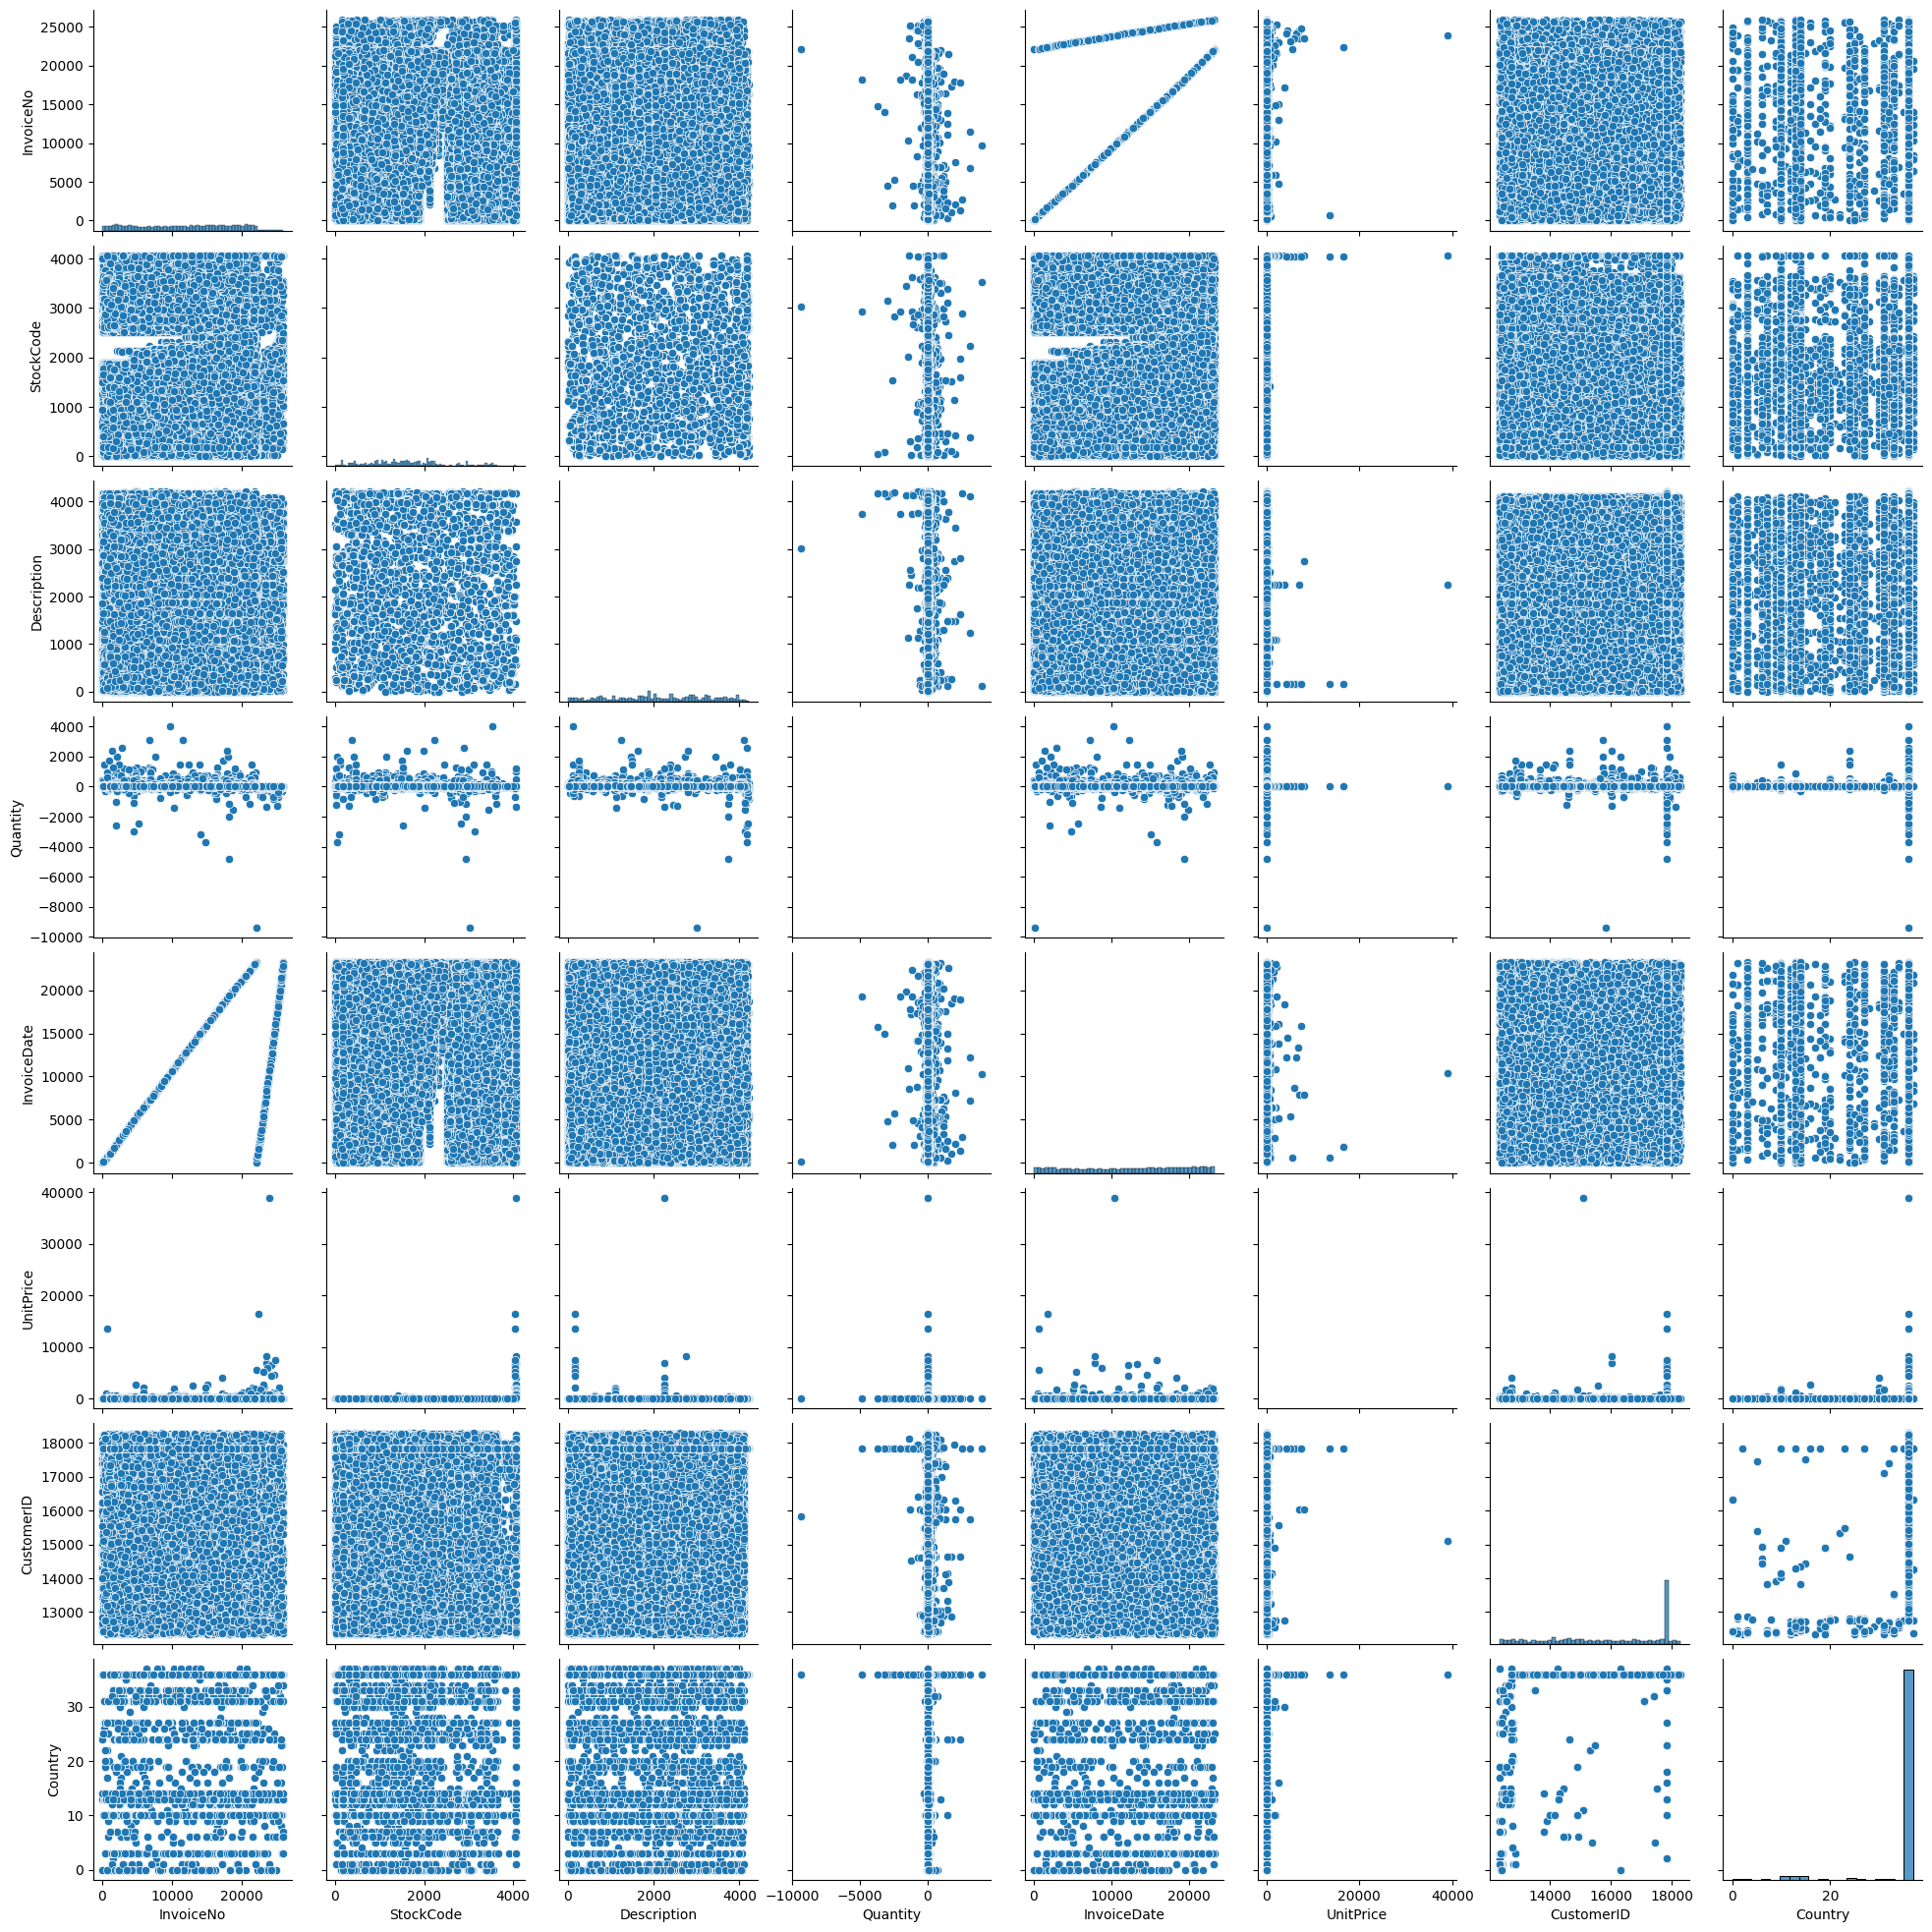

In [5]:
sample = df.sample(frac = 0.25)
sample.reset_index()
sns.pairplot(sample)
plt.show()

C:\Users\anaal\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

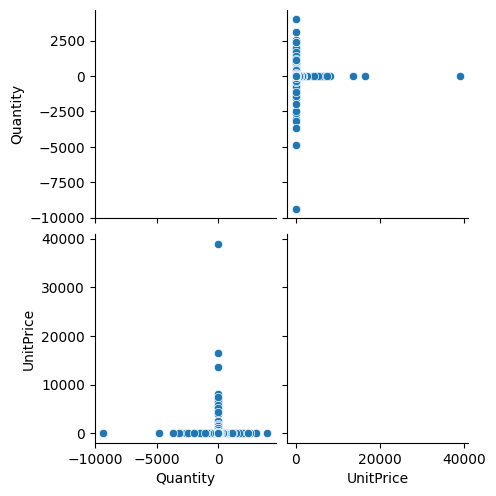

In [6]:
plt.figure()
sns.pairplot(sample,vars=["Quantity","UnitPrice"])
plt.show()

In [18]:
km = KMeans(n_clusters=3)
preds = km.fit_predict(sample)

C:\Users\anaal\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [8]:
print(preds)

[5 0 5 ... 1 1 1]


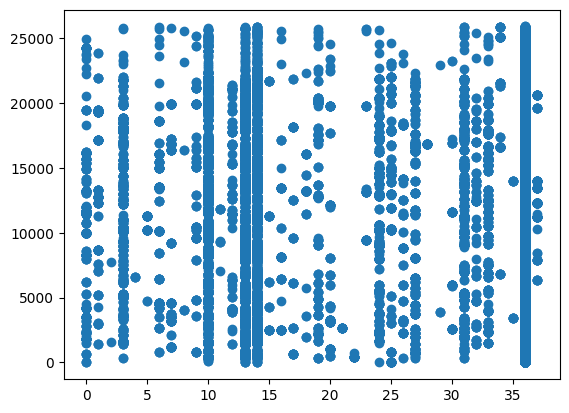

In [9]:
plt.scatter(sample["Country"],sample["InvoiceNo"])

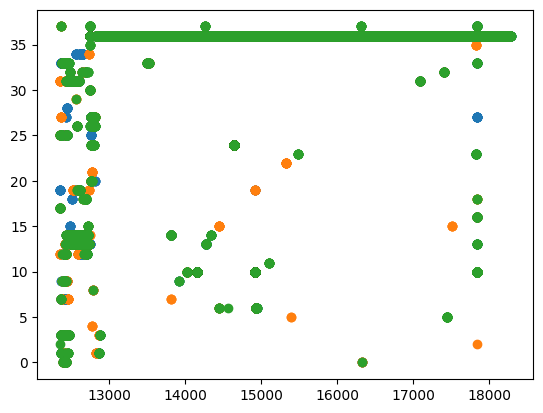

In [19]:
for i in range(3):
    plt.scatter(sample.iloc[preds==i,6], sample.iloc[preds==i,7])

In [21]:
agg = AgglomerativeClustering(n_clusters=4)
s = sample.sample(frac=0.2)
predictions = agg.fit_predict(s)

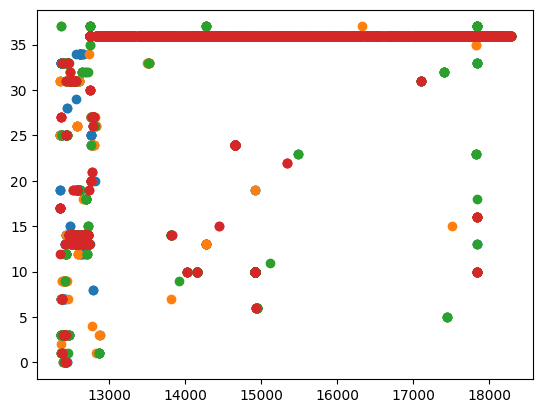

In [22]:
for i in range(4):
    plt.scatter(s.iloc[predictions==i,6], s.iloc[predictions==i,7])